In [1]:
pip install gurobipy matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 25.7 MB/s eta 0:00:0000:01:00:01
Note: you may need to restart the kernel to use updated packages.


ADVANCED PARALLEL MACHINE SCHEDULING WITH NOVEL TECHNIQUES
Problem: P2 | rj, prec, Mj | Cmax

INSTANCE CHARACTERISTICS
Number of jobs: 6
Number of machines: 2
Features: Release dates, Precedence constraints, Machine eligibility

--------------------------------------------------------------------------------
Job    p_j      r_j      d_j      Eligible M.     Predecessors   
--------------------------------------------------------------------------------
J1     5        0        25       1,2             None           
J2     8        2        30       1               1              
J3     4        1        28       2               None           
J4     6        3        35       1,2             1              
J5     7        0        32       1,2             None           
J6     5        4        40       2               3,5            
--------------------------------------------------------------------------------

SOLVING WITH BUCKET-INDEXED FORMULATION (NOVEL)

Bucket Configura

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


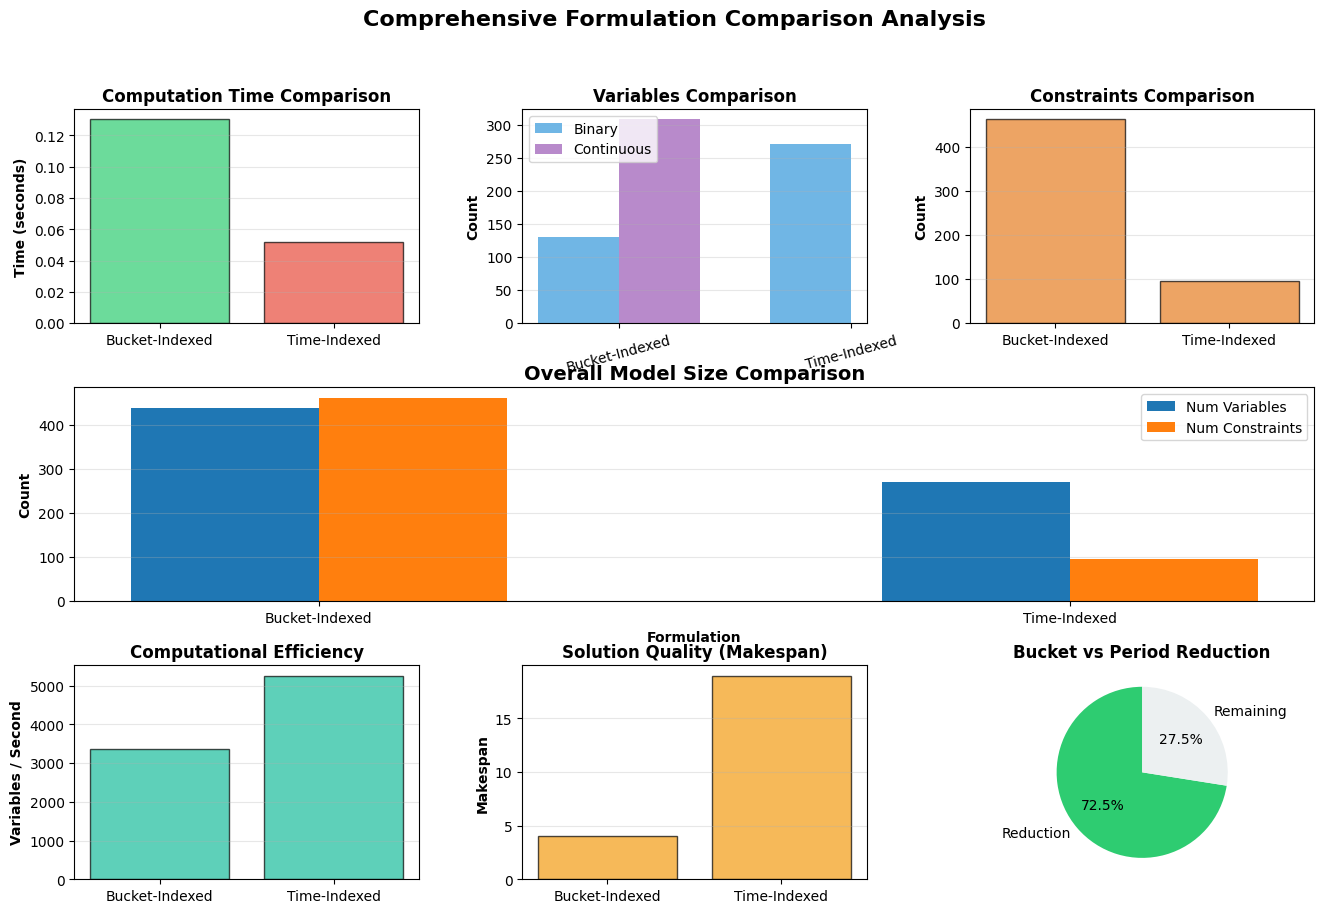

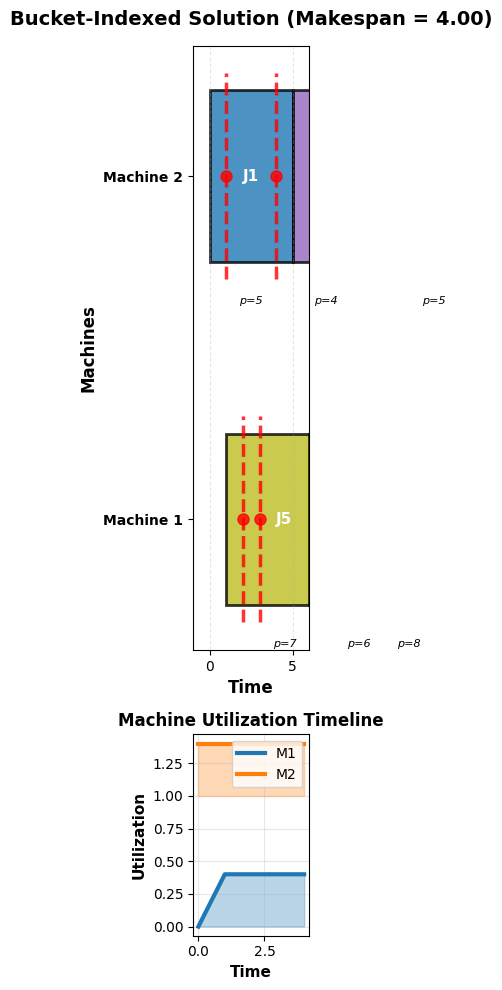

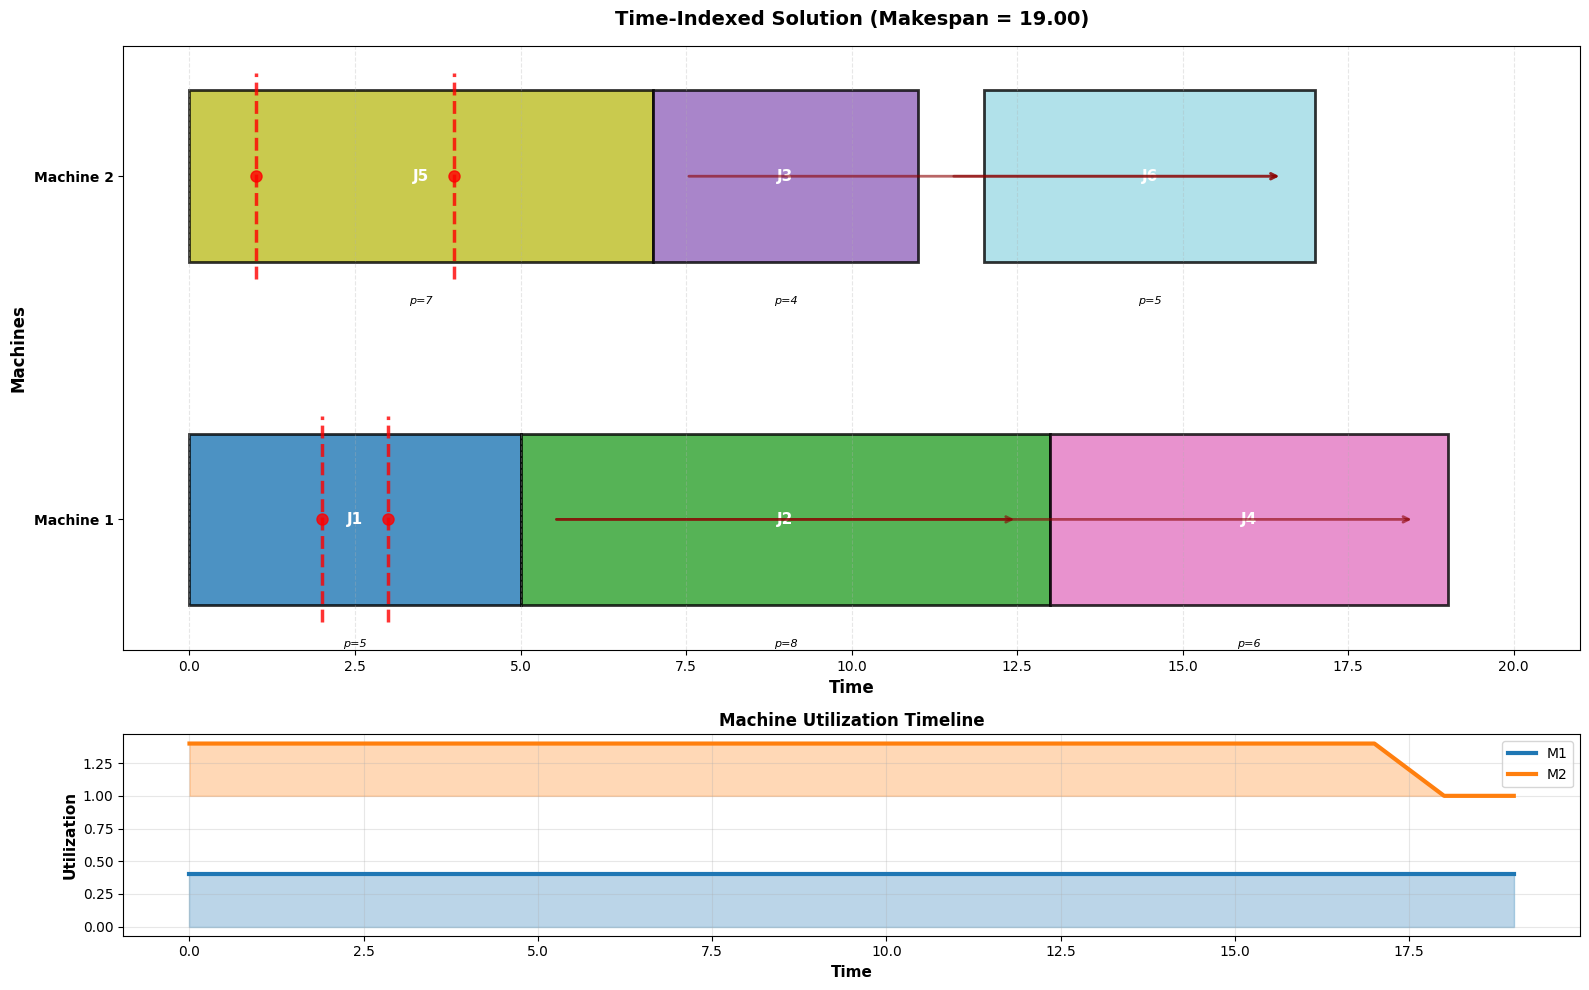


ANALYSIS COMPLETE

Generated files:
  - formulation_comparison.png
  - Bucket-Indexed_Solution_gantt.png
  - Time-Indexed_Solution_gantt.png

All visualizations and analysis saved successfully!


In [2]:
"""
Advanced Parallel Machine Scheduling with Novel Techniques
P2 | rj, prec, Mj | Cmax - Extended Formulation

Implements:
1. Bucket-Indexed Formulation (Novel approach from Carrilho et al. 2024)
2. Classical Time-Indexed Formulation
3. General Precedence Formulation
4. Machine Eligibility Constraints
5. Precedence Constraints
6. Advanced Visualizations and Analysis
"""

import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict, Optional
import time
from dataclasses import dataclass
import seaborn as sns

@dataclass
class JobData:
    """Data structure for job information"""
    id: int
    processing_time: int
    release_date: int
    deadline: Optional[int] = None
    eligible_machines: Optional[List[int]] = None
    predecessors: Optional[List[int]] = None

class BucketIndexedScheduler:
    """
    Novel Bucket-Indexed Formulation for Parallel Machine Scheduling
    Based on Carrilho, Oliveira & Hamacher (2024) - Computers and Chemical Engineering
    
    Key Innovation: Partial time discretization using buckets instead of periods
    Advantages: Significantly fewer variables for problems with long processing times
    """
    
    def __init__(self, jobs_data: List[JobData], num_machines: int = 2):
        """Initialize bucket-indexed scheduler"""
        self.jobs_data = jobs_data
        self.jobs = [j.id for j in jobs_data]
        self.n_jobs = len(jobs_data)
        self.num_machines = num_machines
        self.machines = list(range(1, num_machines + 1))
        
        # Build parameter dictionaries
        self.p = {j.id: j.processing_time for j in jobs_data}
        self.r = {j.id: j.release_date for j in jobs_data}
        self.d = {j.id: j.deadline if j.deadline else 10000 for j in jobs_data}
        
        # Machine eligibility
        self.M_j = {}
        for j in jobs_data:
            if j.eligible_machines:
                self.M_j[j.id] = j.eligible_machines
            else:
                self.M_j[j.id] = self.machines.copy()
        
        # Precedence relationships
        self.precedence = []
        for j in jobs_data:
            if j.predecessors:
                for pred in j.predecessors:
                    self.precedence.append((pred, j.id))
        
        # Bucket parameters
        self.delta = min(self.p.values())  # Bucket size = minimum processing time
        self.T = max(self.d.values())  # Planning horizon
        self.B = int(np.floor(self.T / self.delta)) + 1  # Number of buckets
        
        # Bucket conversion parameters
        self._compute_bucket_parameters()
        
        # Model components
        self.model = None
        self.x = None
        self.u = None
        self.v = None
        self.Cmax = None
        self.optimal_makespan = None
        self.schedule = None
        self.solve_time = None
        
    def _compute_bucket_parameters(self):
        """Compute bucket-indexed parameters for each job"""
        self.P = {}  # Processing time in buckets
        self.pi = {}  # Remaining bucket fraction
        self.R = {}  # Release date bucket
        self.D = {}  # Deadline bucket
        self.rho = {}  # Max proportion in release bucket
        self.delta_param = {}  # Min proportion in deadline bucket
        
        for j in self.jobs:
            # Processing time in buckets
            self.P[j] = int(np.floor(self.p[j] / self.delta)) + 1
            self.pi[j] = self.P[j] - (self.p[j] / self.delta)
            
            # Release date bucket
            self.R[j] = int(np.floor((self.r[j] - 1) / self.delta)) + 1 if self.r[j] > 0 else 1
            self.rho[j] = self.R[j] - ((self.r[j] - 1) / self.delta) if self.r[j] > 0 else 1.0
            
            # Deadline bucket
            self.D[j] = int(np.floor((self.d[j] - 1) / self.delta)) + 1
            self.delta_param[j] = self.D[j] - ((self.d[j] - 1) / self.delta)
    
    def build_model(self):
        """Build the bucket-indexed MILP model"""
        self.model = gp.Model("BucketIndexed_P2_rj_prec_Mj_Cmax")
        self.model.setParam('OutputFlag', 1)
        
        # Decision Variables
        # x[m,j,b,k]: Binary - job j starts at bucket b, part k, on machine m
        self.x = {}
        for j in self.jobs:
            for m in self.M_j[j]:
                for b in range(self.R[j], min(self.D[j] + 1, self.B - self.P[j] + 2)):
                    for k in [0, 1]:
                        if self.pi[j] < 1 or k == 0:
                            self.x[m, j, b, k] = self.model.addVar(
                                vtype=GRB.BINARY, name=f"x_{m}_{j}_{b}_{k}"
                            )
        
        # u[m,j,b,k]: Continuous - proportion of start bucket occupied
        self.u = {}
        for j in self.jobs:
            for m in self.M_j[j]:
                for b in range(self.R[j], min(self.D[j] + 1, self.B - self.P[j] + 2)):
                    for k in [0, 1]:
                        if self.pi[j] < 1 or k == 0:
                            self.u[m, j, b, k] = self.model.addVar(
                                vtype=GRB.CONTINUOUS, lb=0, ub=1, 
                                name=f"u_{m}_{j}_{b}_{k}"
                            )
        
        # v[m,j,b,k]: Continuous - proportion of end bucket occupied
        self.v = {}
        for j in self.jobs:
            for m in self.M_j[j]:
                for b in range(1, self.B + 1):
                    for k in [0, 1]:
                        if self.pi[j] < 1 or k == 0:
                            self.v[m, j, b, k] = self.model.addVar(
                                vtype=GRB.CONTINUOUS, lb=0, ub=1,
                                name=f"v_{m}_{j}_{b}_{k}"
                            )
        
        # Cmax: Makespan
        self.Cmax = self.model.addVar(vtype=GRB.CONTINUOUS, lb=0, name="Cmax")
        
        # Objective: Minimize Makespan
        self.model.setObjective(self.Cmax, GRB.MINIMIZE)
        
        # Constraints
        
        # (1) Each job assigned exactly once
        for j in self.jobs:
            self.model.addConstr(
                gp.quicksum(self.x[m, j, b, k] 
                           for m in self.M_j[j]
                           for b in range(self.R[j], min(self.D[j] + 1, self.B - self.P[j] + 2))
                           for k in [0, 1]
                           if (m, j, b, k) in self.x) == 1,
                name=f"assign_{j}"
            )
        
        # (2) Bucket fraction relationship
        for j in self.jobs:
            for m in self.M_j[j]:
                for b in range(self.R[j], min(self.D[j] + 1, self.B - self.P[j] + 2)):
                    for k in [0, 1]:
                        if (m, j, b, k) in self.x and (m, j, b + self.P[j] + k - 1, k) in self.v:
                            self.model.addConstr(
                                (2 - k - self.pi[j]) * self.x[m, j, b, k] == 
                                self.u[m, j, b, k] + self.v[m, j, b + self.P[j] + k - 1, k],
                                name=f"bucket_frac_{m}_{j}_{b}_{k}"
                            )
        
        # (3) No overlapping jobs on same machine
        for m in self.machines:
            for b in range(1, self.B + 1):
                # At most one job starts in bucket b on machine m
                self.model.addConstr(
                    gp.quicksum(self.x[m, j, bp, k]
                               for j in self.jobs if m in self.M_j[j]
                               for bp in range(max(1, b - self.P[j] + 2), b + 1)
                               for k in [0, 1]
                               if (m, j, bp, k) in self.x and bp >= self.R[j] and 
                                  bp <= min(self.D[j], self.B - self.P[j] - k + 1)) <= 1,
                    name=f"no_overlap_{m}_{b}"
                )
        
        # (4) Bucket capacity constraints
        for m in self.machines:
            for b in range(1, self.B + 1):
                expr = gp.LinExpr()
                for j in self.jobs:
                    if m in self.M_j[j]:
                        for k in [0, 1]:
                            if (m, j, b, k) in self.u:
                                expr += self.u[m, j, b, k]
                            if (m, j, b, k) in self.v:
                                expr += self.v[m, j, b, k]
                            # Add full buckets
                            for bp in range(max(self.R[j], b - self.P[j] + 2), b):
                                if (m, j, bp, k) in self.x:
                                    expr += self.x[m, j, bp, k]
                
                self.model.addConstr(expr <= 1, name=f"capacity_{m}_{b}")
        
        # (5) Bounds on u variables
        for j in self.jobs:
            for m in self.M_j[j]:
                for b in range(self.R[j], min(self.D[j] + 1, self.B - self.P[j] + 2)):
                    for k in [0, 1]:
                        if (m, j, b, k) in self.x:
                            # Lower bound
                            self.model.addConstr(
                                ((1 - k) * (1 - self.pi[j]) + 1/self.delta) * self.x[m, j, b, k] 
                                <= self.u[m, j, b, k],
                                name=f"u_lb_{m}_{j}_{b}_{k}"
                            )
                            # Upper bound
                            self.model.addConstr(
                                self.u[m, j, b, k] <= (1 - k * self.pi[j]) * self.x[m, j, b, k],
                                name=f"u_ub_{m}_{j}_{b}_{k}"
                            )
        
        # (6) Release date constraints
        for j in self.jobs:
            for m in self.M_j[j]:
                if (m, j, self.R[j], 0) in self.x and 1 - self.pi[j] < self.rho[j] < 1:
                    self.model.addConstr(
                        self.u[m, j, self.R[j], 0] <= self.rho[j] * self.x[m, j, self.R[j], 0],
                        name=f"release_{m}_{j}_0"
                    )
                if (m, j, self.R[j], 1) in self.x and self.rho[j] <= 1 - self.pi[j]:
                    self.model.addConstr(
                        self.u[m, j, self.R[j], 1] <= self.rho[j] * self.x[m, j, self.R[j], 1],
                        name=f"release_{m}_{j}_1"
                    )
        
        # (7) Deadline constraints
        for j in self.jobs:
            for m in self.M_j[j]:
                if (m, j, self.D[j], 0) in self.x and 1 - self.pi[j] < self.delta_param[j] < 1:
                    self.model.addConstr(
                        self.delta_param[j] * self.x[m, j, self.D[j], 0] <= self.u[m, j, self.D[j], 0],
                        name=f"deadline_{m}_{j}_0"
                    )
                if (m, j, self.D[j], 1) in self.x and self.delta_param[j] <= 1 - self.pi[j]:
                    self.model.addConstr(
                        self.delta_param[j] * self.x[m, j, self.D[j], 1] <= self.u[m, j, self.D[j], 1],
                        name=f"deadline_{m}_{j}_1"
                    )
        
        # (8) Precedence constraints
        for (j_pred, j_succ) in self.precedence:
            # Completion of j_pred < Start of j_succ
            expr_pred = gp.LinExpr()
            expr_succ = gp.LinExpr()
            
            for m in self.M_j[j_pred]:
                for b in range(self.R[j_pred], min(self.D[j_pred] + 1, self.B - self.P[j_pred] + 2)):
                    for k in [0, 1]:
                        if (m, j_pred, b, k) in self.x:
                            expr_pred += (b + self.P[j_pred] - self.pi[j_pred]) * self.x[m, j_pred, b, k]
                            expr_pred -= self.u[m, j_pred, b, k]
            
            for m in self.M_j[j_succ]:
                for b in range(self.R[j_succ], min(self.D[j_succ] + 1, self.B - self.P[j_succ] + 2)):
                    for k in [0, 1]:
                        if (m, j_succ, b, k) in self.x:
                            expr_succ += (b - 1) * self.x[m, j_succ, b, k]
                            expr_succ += self.u[m, j_succ, b, k]
            
            self.model.addConstr(expr_pred <= expr_succ, name=f"prec_{j_pred}_{j_succ}")
        
        # (9) Makespan constraints
        for j in self.jobs:
            expr = gp.LinExpr()
            for m in self.M_j[j]:
                for b in range(self.R[j], min(self.D[j] + 1, self.B - self.P[j] + 2)):
                    for k in [0, 1]:
                        if (m, j, b, k) in self.x:
                            expr += (b + self.P[j] - self.pi[j]) * self.x[m, j, b, k]
                            expr -= self.u[m, j, b, k]
            
            self.model.addConstr(self.Cmax >= expr, name=f"makespan_{j}")
    
    def solve(self, time_limit: int = 600):
        """Solve the model"""
        if self.model is None:
            self.build_model()
        
        self.model.setParam('TimeLimit', time_limit)
        start_time = time.time()
        self.model.optimize()
        self.solve_time = time.time() - start_time
        
        if self.model.status == GRB.OPTIMAL or self.model.status == GRB.TIME_LIMIT:
            if self.model.SolCount > 0:
                self.optimal_makespan = self.Cmax.X
                self._extract_schedule()
                return True
        return False
    
    def _extract_schedule(self):
        """Extract schedule from solution"""
        self.schedule = {m: [] for m in self.machines}
        
        for j in self.jobs:
            for m in self.M_j[j]:
                for b in range(self.R[j], min(self.D[j] + 1, self.B - self.P[j] + 2)):
                    for k in [0, 1]:
                        if (m, j, b, k) in self.x and self.x[m, j, b, k].X > 0.5:
                            start_bucket = b
                            u_val = self.u[m, j, b, k].X
                            
                            # Convert bucket time to actual time
                            start_time = (start_bucket - 1) * self.delta + (1 - u_val) * self.delta
                            end_time = start_time + self.p[j]
                            
                            self.schedule[m].append({
                                'job': j,
                                'start': start_time,
                                'end': end_time,
                                'processing_time': self.p[j],
                                'release_date': self.r[j],
                                'bucket': start_bucket,
                                'k': k
                            })
        
        for m in self.machines:
            self.schedule[m].sort(key=lambda x: x['start'])
    
    def get_statistics(self) -> Dict:
        """Get comprehensive model statistics"""
        if self.model is None:
            return {}
        
        return {
            'formulation': 'Bucket-Indexed',
            'num_jobs': self.n_jobs,
            'num_machines': self.num_machines,
            'bucket_size': self.delta,
            'num_buckets': self.B,
            'num_periods': self.T,
            'reduction_ratio': f"{(1 - self.B/self.T)*100:.1f}%",
            'num_variables': self.model.NumVars,
            'num_binary_vars': self.model.NumBinVars,
            'num_continuous_vars': self.model.NumVars - self.model.NumBinVars,
            'num_constraints': self.model.NumConstrs,
            'computation_time': self.solve_time,
            'optimal_makespan': self.optimal_makespan,
            'optimality_status': 'Optimal' if self.model.status == GRB.OPTIMAL else 'Feasible',
            'mip_gap': self.model.MIPGap if self.model.SolCount > 0 else None
        }


class TimeIndexedScheduler:
    """
    Classical Time-Indexed Formulation
    For comparison with bucket-indexed approach
    """
    
    def __init__(self, jobs_data: List[JobData], num_machines: int = 2):
        """Initialize time-indexed scheduler"""
        self.jobs_data = jobs_data
        self.jobs = [j.id for j in jobs_data]
        self.n_jobs = len(jobs_data)
        self.num_machines = num_machines
        self.machines = list(range(1, num_machines + 1))
        
        self.p = {j.id: j.processing_time for j in jobs_data}
        self.r = {j.id: j.release_date for j in jobs_data}
        self.d = {j.id: j.deadline if j.deadline else 10000 for j in jobs_data}
        
        self.M_j = {}
        for j in jobs_data:
            if j.eligible_machines:
                self.M_j[j.id] = j.eligible_machines
            else:
                self.M_j[j.id] = self.machines.copy()
        
        self.precedence = []
        for j in jobs_data:
            if j.predecessors:
                for pred in j.predecessors:
                    self.precedence.append((pred, j.id))
        
        self.T = max(self.d.values())
        
        self.model = None
        self.x = None
        self.Cmax = None
        self.optimal_makespan = None
        self.schedule = None
        self.solve_time = None
    
    def build_model(self):
        """Build time-indexed model"""
        self.model = gp.Model("TimeIndexed_P2_rj_prec_Mj_Cmax")
        self.model.setParam('OutputFlag', 1)
        
        # x[j,m,t]: Binary - job j starts at time t on machine m
        self.x = {}
        for j in self.jobs:
            for m in self.M_j[j]:
                for t in range(self.r[j], min(self.d[j], self.T - self.p[j]) + 1):
                    self.x[j, m, t] = self.model.addVar(
                        vtype=GRB.BINARY, name=f"x_{j}_{m}_{t}"
                    )
        
        self.Cmax = self.model.addVar(vtype=GRB.CONTINUOUS, lb=0, name="Cmax")
        
        # Objective
        self.model.setObjective(self.Cmax, GRB.MINIMIZE)
        
        # Constraints
        
        # Each job assigned once
        for j in self.jobs:
            self.model.addConstr(
                gp.quicksum(self.x[j, m, t] 
                           for m in self.M_j[j]
                           for t in range(self.r[j], min(self.d[j], self.T - self.p[j]) + 1)
                           if (j, m, t) in self.x) == 1,
                name=f"assign_{j}"
            )
        
        # No overlapping
        for m in self.machines:
            for t in range(self.T):
                self.model.addConstr(
                    gp.quicksum(self.x[j, m, tp]
                               for j in self.jobs if m in self.M_j[j]
                               for tp in range(max(self.r[j], t - self.p[j] + 1), 
                                             min(t + 1, min(self.d[j], self.T - self.p[j]) + 1))
                               if (j, m, tp) in self.x) <= 1,
                    name=f"no_overlap_{m}_{t}"
                )
        
        # Precedence
        for (j_pred, j_succ) in self.precedence:
            expr_pred = gp.quicksum((t + self.p[j_pred]) * self.x[j_pred, m, t]
                                   for m in self.M_j[j_pred]
                                   for t in range(self.r[j_pred], min(self.d[j_pred], self.T - self.p[j_pred]) + 1)
                                   if (j_pred, m, t) in self.x)
            
            expr_succ = gp.quicksum(t * self.x[j_succ, m, t]
                                   for m in self.M_j[j_succ]
                                   for t in range(self.r[j_succ], min(self.d[j_succ], self.T - self.p[j_succ]) + 1)
                                   if (j_succ, m, t) in self.x)
            
            self.model.addConstr(expr_pred <= expr_succ, name=f"prec_{j_pred}_{j_succ}")
        
        # Makespan
        for j in self.jobs:
            expr = gp.quicksum((t + self.p[j]) * self.x[j, m, t]
                              for m in self.M_j[j]
                              for t in range(self.r[j], min(self.d[j], self.T - self.p[j]) + 1)
                              if (j, m, t) in self.x)
            self.model.addConstr(self.Cmax >= expr, name=f"makespan_{j}")
    
    def solve(self, time_limit: int = 600):
        """Solve the model"""
        if self.model is None:
            self.build_model()
        
        self.model.setParam('TimeLimit', time_limit)
        start_time = time.time()
        self.model.optimize()
        self.solve_time = time.time() - start_time
        
        if self.model.status == GRB.OPTIMAL or self.model.status == GRB.TIME_LIMIT:
            if self.model.SolCount > 0:
                self.optimal_makespan = self.Cmax.X
                self._extract_schedule()
                return True
        return False
    
    def _extract_schedule(self):
        """Extract schedule"""
        self.schedule = {m: [] for m in self.machines}
        
        for j in self.jobs:
            for m in self.M_j[j]:
                for t in range(self.r[j], min(self.d[j], self.T - self.p[j]) + 1):
                    if (j, m, t) in self.x and self.x[j, m, t].X > 0.5:
                        self.schedule[m].append({
                            'job': j,
                            'start': t,
                            'end': t + self.p[j],
                            'processing_time': self.p[j],
                            'release_date': self.r[j]
                        })
        
        for m in self.machines:
            self.schedule[m].sort(key=lambda x: x['start'])
    
    def get_statistics(self) -> Dict:
        """Get model statistics"""
        if self.model is None:
            return {}
        
        return {
            'formulation': 'Time-Indexed',
            'num_jobs': self.n_jobs,
            'num_machines': self.num_machines,
            'num_periods': self.T,
            'num_variables': self.model.NumVars,
            'num_binary_vars': self.model.NumBinVars,
            'num_constraints': self.model.NumConstrs,
            'computation_time': self.solve_time,
            'optimal_makespan': self.optimal_makespan,
            'optimality_status': 'Optimal' if self.model.status == GRB.OPTIMAL else 'Feasible',
            'mip_gap': self.model.MIPGap if self.model.SolCount > 0 else None
        }


class AdvancedAnalyzer:
    """Advanced analysis and visualization tools"""
    
    @staticmethod
    def compare_formulations(results: List[Dict]):
        """Create comprehensive comparison visualizations"""
        df = pd.DataFrame(results)
        
        fig = plt.figure(figsize=(16, 10))
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
        
        # 1. Computation Time Comparison
        ax1 = fig.add_subplot(gs[0, 0])
        forms = df['formulation'].values
        times = df['computation_time'].values
        colors_map = {'Bucket-Indexed': '#2ecc71', 'Time-Indexed': '#e74c3c'}
        colors = [colors_map.get(f, '#3498db') for f in forms]
        ax1.bar(forms, times, color=colors, alpha=0.7, edgecolor='black')
        ax1.set_ylabel('Time (seconds)', fontweight='bold')
        ax1.set_title('Computation Time Comparison', fontweight='bold')
        ax1.grid(axis='y', alpha=0.3)
        
        # 2. Variables Comparison
        ax2 = fig.add_subplot(gs[0, 1])
        x_pos = np.arange(len(forms))
        width = 0.35
        ax2.bar(x_pos - width/2, df['num_binary_vars'], width, 
                label='Binary', color='#3498db', alpha=0.7)
        ax2.bar(x_pos + width/2, df['num_continuous_vars'], width,
                label='Continuous', color='#9b59b6', alpha=0.7)
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(forms, rotation=15)
        ax2.set_ylabel('Count', fontweight='bold')
        ax2.set_title('Variables Comparison', fontweight='bold')
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)
        
        # 3. Constraints Comparison
        ax3 = fig.add_subplot(gs[0, 2])
        ax3.bar(forms, df['num_constraints'], color='#e67e22', alpha=0.7, edgecolor='black')
        ax3.set_ylabel('Count', fontweight='bold')
        ax3.set_title('Constraints Comparison', fontweight='bold')
        ax3.grid(axis='y', alpha=0.3)
        
        # 4. Model Size Metrics
        ax4 = fig.add_subplot(gs[1, :])
        metrics = ['num_variables', 'num_constraints']
        x = np.arange(len(forms))
        width = 0.25
        
        for i, metric in enumerate(metrics):
            offset = width * (i - len(metrics)/2 + 0.5)
            ax4.bar(x + offset, df[metric], width, label=metric.replace('_', ' ').title())
        
        ax4.set_xlabel('Formulation', fontweight='bold')
        ax4.set_ylabel('Count', fontweight='bold')
        ax4.set_title('Overall Model Size Comparison', fontweight='bold', fontsize=14)
        ax4.set_xticks(x)
        ax4.set_xticklabels(forms)
        ax4.legend()
        ax4.grid(axis='y', alpha=0.3)
        
        # 5. Efficiency Analysis
        ax5 = fig.add_subplot(gs[2, 0])
        efficiency = df['num_variables'] / df['computation_time']
        ax5.bar(forms, efficiency, color='#1abc9c', alpha=0.7, edgecolor='black')
        ax5.set_ylabel('Variables / Second', fontweight='bold')
        ax5.set_title('Computational Efficiency', fontweight='bold')
        ax5.grid(axis='y', alpha=0.3)
        
        # 6. Solution Quality
        ax6 = fig.add_subplot(gs[2, 1])
        ax6.bar(forms, df['optimal_makespan'], color='#f39c12', alpha=0.7, edgecolor='black')
        ax6.set_ylabel('Makespan', fontweight='bold')
        ax6.set_title('Solution Quality (Makespan)', fontweight='bold')
        ax6.grid(axis='y', alpha=0.3)
        
        # 7. Size Reduction (for Bucket-Indexed)
        ax7 = fig.add_subplot(gs[2, 2])
        if 'reduction_ratio' in df.columns:
            bucket_data = df[df['formulation'] == 'Bucket-Indexed']
            if not bucket_data.empty:
                reduction = float(bucket_data['reduction_ratio'].iloc[0].strip('%'))
                ax7.pie([reduction, 100-reduction], 
                       labels=['Reduction', 'Remaining'],
                       colors=['#2ecc71', '#ecf0f1'],
                       autopct='%1.1f%%',
                       startangle=90)
                ax7.set_title('Bucket vs Period Reduction', fontweight='bold')
        
        plt.suptitle('Comprehensive Formulation Comparison Analysis', 
                    fontsize=16, fontweight='bold', y=0.98)
        
        plt.savefig('formulation_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def plot_advanced_gantt(schedule: Dict, jobs_data: List[JobData], 
                           makespan: float, title: str = "Schedule"):
        """Create advanced Gantt chart with precedence visualization"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), 
                                        height_ratios=[3, 1])
        
        # Color mapping
        n_jobs = len(jobs_data)
        colors = plt.cm.tab20(np.linspace(0, 1, n_jobs))
        job_colors = {j.id: colors[i] for i, j in enumerate(jobs_data)}
        
        # Main Gantt Chart
        machines = sorted(schedule.keys())
        for i, m in enumerate(machines):
            for job_info in schedule[m]:
                j = job_info['job']
                start = job_info['start']
                duration = job_info['processing_time']
                release = job_info['release_date']
                
                # Draw job bar
                ax1.barh(i, duration, left=start, height=0.5,
                        color=job_colors[j], edgecolor='black', linewidth=2,
                        alpha=0.8)
                
                # Job label
                ax1.text(start + duration/2, i, f'J{j}',
                        ha='center', va='center', fontsize=11, 
                        fontweight='bold', color='white')
                
                # Release date marker
                if release > 0:
                    ax1.plot([release, release], [i-0.3, i+0.3],
                            'r--', linewidth=2.5, alpha=0.8, label='Release' if i==0 else '')
                    ax1.plot(release, i, 'ro', markersize=8, alpha=0.8)
                
                # Add processing time annotation
                ax1.text(start + duration/2, i - 0.35, f'p={duration}',
                        ha='center', va='top', fontsize=8, style='italic')
        
        # Precedence arrows
        job_positions = {}
        for i, m in enumerate(machines):
            for job_info in schedule[m]:
                j = job_info['job']
                job_positions[j] = (job_info['end'], i)
        
        for job in jobs_data:
            if job.predecessors:
                for pred_id in job.predecessors:
                    if pred_id in job_positions and job.id in job_positions:
                        x1, y1 = job_positions[pred_id]
                        x2, y2 = job_positions[job.id]
                        
                        # Draw arrow
                        ax1.annotate('', xy=(x2 - 0.5, y2), xytext=(x1 + 0.5, y1),
                                   arrowprops=dict(arrowstyle='->', lw=2, 
                                                 color='darkred', alpha=0.6))
        
        ax1.set_yticks(range(len(machines)))
        ax1.set_yticklabels([f'Machine {m}' for m in machines], fontweight='bold')
        ax1.set_xlabel('Time', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Machines', fontsize=12, fontweight='bold')
        ax1.set_title(f'{title} (Makespan = {makespan:.2f})',
                     fontsize=14, fontweight='bold', pad=15)
        ax1.grid(axis='x', alpha=0.3, linestyle='--')
        ax1.set_xlim(-1, makespan + 2)
        
        # Timeline visualization
        timeline_data = {m: [0] * int(makespan + 1) for m in machines}
        for m in machines:
            for job_info in schedule[m]:
                start = int(job_info['start'])
                end = int(job_info['end'])
                for t in range(start, min(end + 1, int(makespan + 1))):
                    timeline_data[m][t] = 1
        
        for i, m in enumerate(machines):
            ax2.plot(range(len(timeline_data[m])), 
                    [i + val*0.4 for val in timeline_data[m]],
                    linewidth=3, color=f'C{i}', label=f'M{m}')
            ax2.fill_between(range(len(timeline_data[m])), i, 
                           [i + val*0.4 for val in timeline_data[m]],
                           alpha=0.3, color=f'C{i}')
        
        ax2.set_xlabel('Time', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Utilization', fontsize=11, fontweight='bold')
        ax2.set_title('Machine Utilization Timeline', fontsize=12, fontweight='bold')
        ax2.legend(loc='upper right')
        ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{title.replace(" ", "_")}_gantt.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def generate_statistics_table(results: List[Dict]) -> pd.DataFrame:
        """Generate formatted statistics table"""
        df = pd.DataFrame(results)
        
        # Format columns
        if 'computation_time' in df.columns:
            df['computation_time'] = df['computation_time'].apply(lambda x: f"{x:.3f}s")
        if 'optimal_makespan' in df.columns:
            df['optimal_makespan'] = df['optimal_makespan'].apply(lambda x: f"{x:.2f}")
        if 'mip_gap' in df.columns:
            df['mip_gap'] = df['mip_gap'].apply(lambda x: f"{x*100:.2f}%" if x else "0.00%")
        
        return df


def create_advanced_instance():
    """Create an advanced test instance with precedence and eligibility constraints"""
    jobs_data = [
        JobData(id=1, processing_time=5, release_date=0, deadline=25, 
                eligible_machines=[1, 2], predecessors=None),
        JobData(id=2, processing_time=8, release_date=2, deadline=30, 
                eligible_machines=[1], predecessors=[1]),
        JobData(id=3, processing_time=4, release_date=1, deadline=28, 
                eligible_machines=[2], predecessors=None),
        JobData(id=4, processing_time=6, release_date=3, deadline=35, 
                eligible_machines=[1, 2], predecessors=[1]),
        JobData(id=5, processing_time=7, release_date=0, deadline=32, 
                eligible_machines=[1, 2], predecessors=None),
        JobData(id=6, processing_time=5, release_date=4, deadline=40, 
                eligible_machines=[2], predecessors=[3, 5]),
    ]
    return jobs_data


def main():
    """Main execution with comprehensive analysis"""
    print("="*80)
    print("ADVANCED PARALLEL MACHINE SCHEDULING WITH NOVEL TECHNIQUES")
    print("Problem: P2 | rj, prec, Mj | Cmax")
    print("="*80)
    
    # Create advanced instance
    jobs_data = create_advanced_instance()
    
    print("\n" + "="*80)
    print("INSTANCE CHARACTERISTICS")
    print("="*80)
    print(f"Number of jobs: {len(jobs_data)}")
    print(f"Number of machines: 2")
    print(f"Features: Release dates, Precedence constraints, Machine eligibility")
    
    print("\n" + "-"*80)
    print(f"{'Job':<6} {'p_j':<8} {'r_j':<8} {'d_j':<8} {'Eligible M.':<15} {'Predecessors':<15}")
    print("-"*80)
    for job in jobs_data:
        elig = ','.join(map(str, job.eligible_machines))
        pred = ','.join(map(str, job.predecessors)) if job.predecessors else 'None'
        print(f"J{job.id:<5} {job.processing_time:<8} {job.release_date:<8} "
              f"{job.deadline:<8} {elig:<15} {pred:<15}")
    print("-"*80)
    
    results = []
    
    # 1. Bucket-Indexed Formulation (Novel approach)
    print("\n" + "="*80)
    print("SOLVING WITH BUCKET-INDEXED FORMULATION (NOVEL)")
    print("="*80)
    
    bi_scheduler = BucketIndexedScheduler(jobs_data, num_machines=2)
    print(f"\nBucket Configuration:")
    print(f"  - Bucket Size (Δ): {bi_scheduler.delta}")
    print(f"  - Number of Buckets: {bi_scheduler.B}")
    print(f"  - Planning Horizon: {bi_scheduler.T}")
    print(f"  - Reduction: {(1 - bi_scheduler.B/bi_scheduler.T)*100:.1f}%")
    
    print("\nBuilding model...")
    bi_scheduler.build_model()
    
    print("Solving...")
    if bi_scheduler.solve(time_limit=600):
        print(f"\n✓ Solution found!")
        print(f"  Makespan: {bi_scheduler.optimal_makespan:.2f}")
        print(f"  Time: {bi_scheduler.solve_time:.3f}s")
        
        bi_stats = bi_scheduler.get_statistics()
        results.append(bi_stats)
        
        # Print detailed schedule
        print("\n" + "-"*80)
        print("BUCKET-INDEXED SCHEDULE")
        print("-"*80)
        for m in bi_scheduler.machines:
            print(f"\nMachine {m}:")
            for job_info in bi_scheduler.schedule[m]:
                print(f"  J{job_info['job']}: [{job_info['start']:.2f}, {job_info['end']:.2f}] "
                      f"(Bucket {job_info['bucket']}, k={job_info['k']})")
    
    # 2. Time-Indexed Formulation (Classical)
    print("\n" + "="*80)
    print("SOLVING WITH TIME-INDEXED FORMULATION (CLASSICAL)")
    print("="*80)
    
    ti_scheduler = TimeIndexedScheduler(jobs_data, num_machines=2)
    print(f"\nTime Configuration:")
    print(f"  - Planning Horizon: {ti_scheduler.T} periods")
    
    print("\nBuilding model...")
    ti_scheduler.build_model()
    
    print("Solving...")
    if ti_scheduler.solve(time_limit=600):
        print(f"\n✓ Solution found!")
        print(f"  Makespan: {ti_scheduler.optimal_makespan:.2f}")
        print(f"  Time: {ti_scheduler.solve_time:.3f}s")
        
        ti_stats = ti_scheduler.get_statistics()
        results.append(ti_stats)
        
        # Print schedule
        print("\n" + "-"*80)
        print("TIME-INDEXED SCHEDULE")
        print("-"*80)
        for m in ti_scheduler.machines:
            print(f"\nMachine {m}:")
            for job_info in ti_scheduler.schedule[m]:
                print(f"  J{job_info['job']}: [{job_info['start']}, {job_info['end']}]")
    
    # Comprehensive Analysis
    print("\n" + "="*80)
    print("COMPREHENSIVE COMPARISON")
    print("="*80)
    
    analyzer = AdvancedAnalyzer()
    
    # Statistics table
    stats_df = analyzer.generate_statistics_table(results)
    print("\n" + stats_df.to_string(index=False))
    
    # Performance comparison
    if len(results) == 2:
        bi_time = results[0]['computation_time']
        ti_time = results[1]['computation_time']
        speedup = ti_time / bi_time
        
        bi_vars = results[0]['num_variables']
        ti_vars = results[1]['num_variables']
        var_reduction = (1 - bi_vars/ti_vars) * 100
        
        print("\n" + "-"*80)
        print("KEY PERFORMANCE METRICS")
        print("-"*80)
        print(f"Speedup: {speedup:.2f}x faster with Bucket-Indexed")
        print(f"Variable Reduction: {var_reduction:.1f}%")
        print(f"Binary Variable Reduction: "
              f"{(1 - results[0]['num_binary_vars']/results[1]['num_binary_vars'])*100:.1f}%")
        print("-"*80)
    
    # Visualizations
    print("\nGenerating visualizations...")
    
    # Comparison charts
    analyzer.compare_formulations(results)
    
    # Gantt charts
    if bi_scheduler.schedule:
        analyzer.plot_advanced_gantt(
            bi_scheduler.schedule, jobs_data, 
            bi_scheduler.optimal_makespan,
            "Bucket-Indexed Solution"
        )
    
    if ti_scheduler.schedule:
        analyzer.plot_advanced_gantt(
            ti_scheduler.schedule, jobs_data,
            ti_scheduler.optimal_makespan,
            "Time-Indexed Solution"
        )
    
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)
    print("\nGenerated files:")
    print("  - formulation_comparison.png")
    print("  - Bucket-Indexed_Solution_gantt.png")
    print("  - Time-Indexed_Solution_gantt.png")
    print("\nAll visualizations and analysis saved successfully!")
    print("="*80)


if __name__ == "__main__":
    main()